---
# **データサイエンス基礎　第12回課題**
## **【クラスタ分析】気象データをクラスタリングした結果とその考察**
---
### 1. データの概要
　今回扱うデータは，第7，8，10回と同様，[気象庁の過去の気象データ](https://www.data.jma.go.jp/gmd/risk/obsdl/index.php)より得られる埼玉県熊谷市の気象データをExcelファイルとしてまとめたものである．
> [https://github.com/KHiraGit/sudspg_ds/raw/main/ds07_temp_power_exercise.xlsx](https://github.com/KHiraGit/sudspg_ds/raw/main/ds07_temp_power_exercise.xlsx)  
  
　このExcel形式のデータを処理し，気象データ（観測値）をクラスタリングし，作成されたクラスタについて考察する．
### 2. $YYYY$ 年 $MM$ 月の気象データの階層的クラスタリング
#### (1) データの読み込み
　まず，各シートの1行目に関して，今回タイトルとして扱いたい情報が含まれない．したがって，1行目を無視する必要がある．また，2，3行目もタイトル行として扱うには不備があり，扱いにくい．以上より，1，2，3行目を無視し，データフレームのタイトル行は自分で定義する必要があると考えられる．  
　また，気象データのうち，独立変数として用いられる可能性があるのは，”平均気温”，”最高気温”，”最低気温”，”降水量”，”日照時間”，”降雪量”，”平均風速”，”平均蒸気圧”，”平均湿度”，”平均現地気圧”の10個である．  
　さらに，電力需要のデータは，1日の1時間毎にデータが記録されている．したがって，この平均値をとり，その日の電力需要とする必要がある．  
　重回帰モデルの作成・出力には，Pythonライブラリであるstatsmodelsを利用する．

In [78]:
# ライブラリの読み込み
# %pip install --upgrade pip
# %pip install numpy
# %pip install matplotlib
# %pip install pandas
# %pip install openpyxl
# %pip install sympy
# %pip install scipy
# %pip install re
# %pip install jaconv
# %pip install scikit-learn
# %pip install statsmodels
# %pip install seaborn
# %pip install pmdarima
# %pip install kneed
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning, module='seaborn')
from matplotlib.font_manager import FontProperties
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import random
import sympy as sp
import scipy.stats as stats
import re
import jaconv 
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
import itertools
import matplotlib.dates as mdates
import pmdarima as pm
from IPython.display import clear_output
from sklearn.metrics import r2_score, f1_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from kneed import KneeLocator


# 変数の定義
year = False                   # 対象年度      ：指定しない場合はFalse
month = False                  # 対象月        ：指定しない場合はFalse

# 対象気象データ名（独立変数候補名）
X_name = ['平均気温', '最高気温', '最低気温', '降水量', '日照時間', '降雪量', '平均風速', '平均蒸気圧', '平均湿度', '平均現地気圧']     

# 対象気象データ名（従属変数候補名）
Y_name = '天気概況'     


# 気象データのExcel Sheetの読み込み
df_weather = pd.read_excel( 'ds07_temp_power_exercise.xlsx', 
                        sheet_name='2020熊谷市気象データ_data', skiprows=[0,1,2],
                        names= ['年月日', '平均気温', '', '', '最高気温', '', '', '', '', '最低気温', '', '', '', '', 
                                '降水量', '', '', '', '日照時間', '', '', '', '降雪量', '', '', '', '平均風速', '', '', 
                                '平均蒸気圧', '', '', '平均湿度', '', '', '平均現地気圧', '', '', '', '', '', '天気概況', '', ''])
df_weather['年月日'] = pd.to_datetime(df_weather['年月日'], format='%Y/%m/%d')


# 対象データの抽出（X：独立変数，Y：従属変数）
def dataLoading(year, month, X_name, Y_name):
    if (year == False) and (month != False) :
        X = df_weather[df_weather['年月日'].dt.month == month][X_name]
        Y = df_weather[df_weather['年月日'].dt.month == month][Y_name]

    elif (year != False) and (month == False):
        X = df_weather[df_weather['年月日'].dt.year == year][X_name]
        Y = df_weather[df_weather['年月日'].dt.year == year][Y_name]

    elif (year == False) and (month == False):
        X = df_weather[X_name]
        Y = df_weather[Y_name]

    else :
        X = df_weather[(df_weather['年月日'].dt.year == year) & (df_weather['年月日'].dt.month == month)][X_name]
        Y = df_weather[(df_weather['年月日'].dt.year == year) & (df_weather['年月日'].dt.month == month)][Y_name]

    return (X, Y)

X_weather, Y_target = dataLoading(year, month, X_name, Y_name)


# データの標準化
stdsc = StandardScaler()
X_weather = stdsc.fit_transform(X_weather)

#### (2) デンドログラムとヒートマップの組み合わせを表示
　元データが多すぎると，縦軸に天気概況が表示しきれなくなる恐れがあることに加え，これまでの課題で，気象データを説明変数として，回帰や決定木モデルを構築できたことから，天気概況が気象データの関数で表すことができると言い換えることができ，同じ天気概況のものがあるとそれらの距離が小さくなることは，自明である．同じ天気概況のものがあると，似た天気概況との距離の結果が見えにくくなり，考察しづらくなるため，今回は，同じ天気概況のデータは，それぞれの気象データの平均を取って1つにまとめる．  
　距離の算出方法については，それぞれ試したが，あまり差は見られなかったため，ward法を用いた．

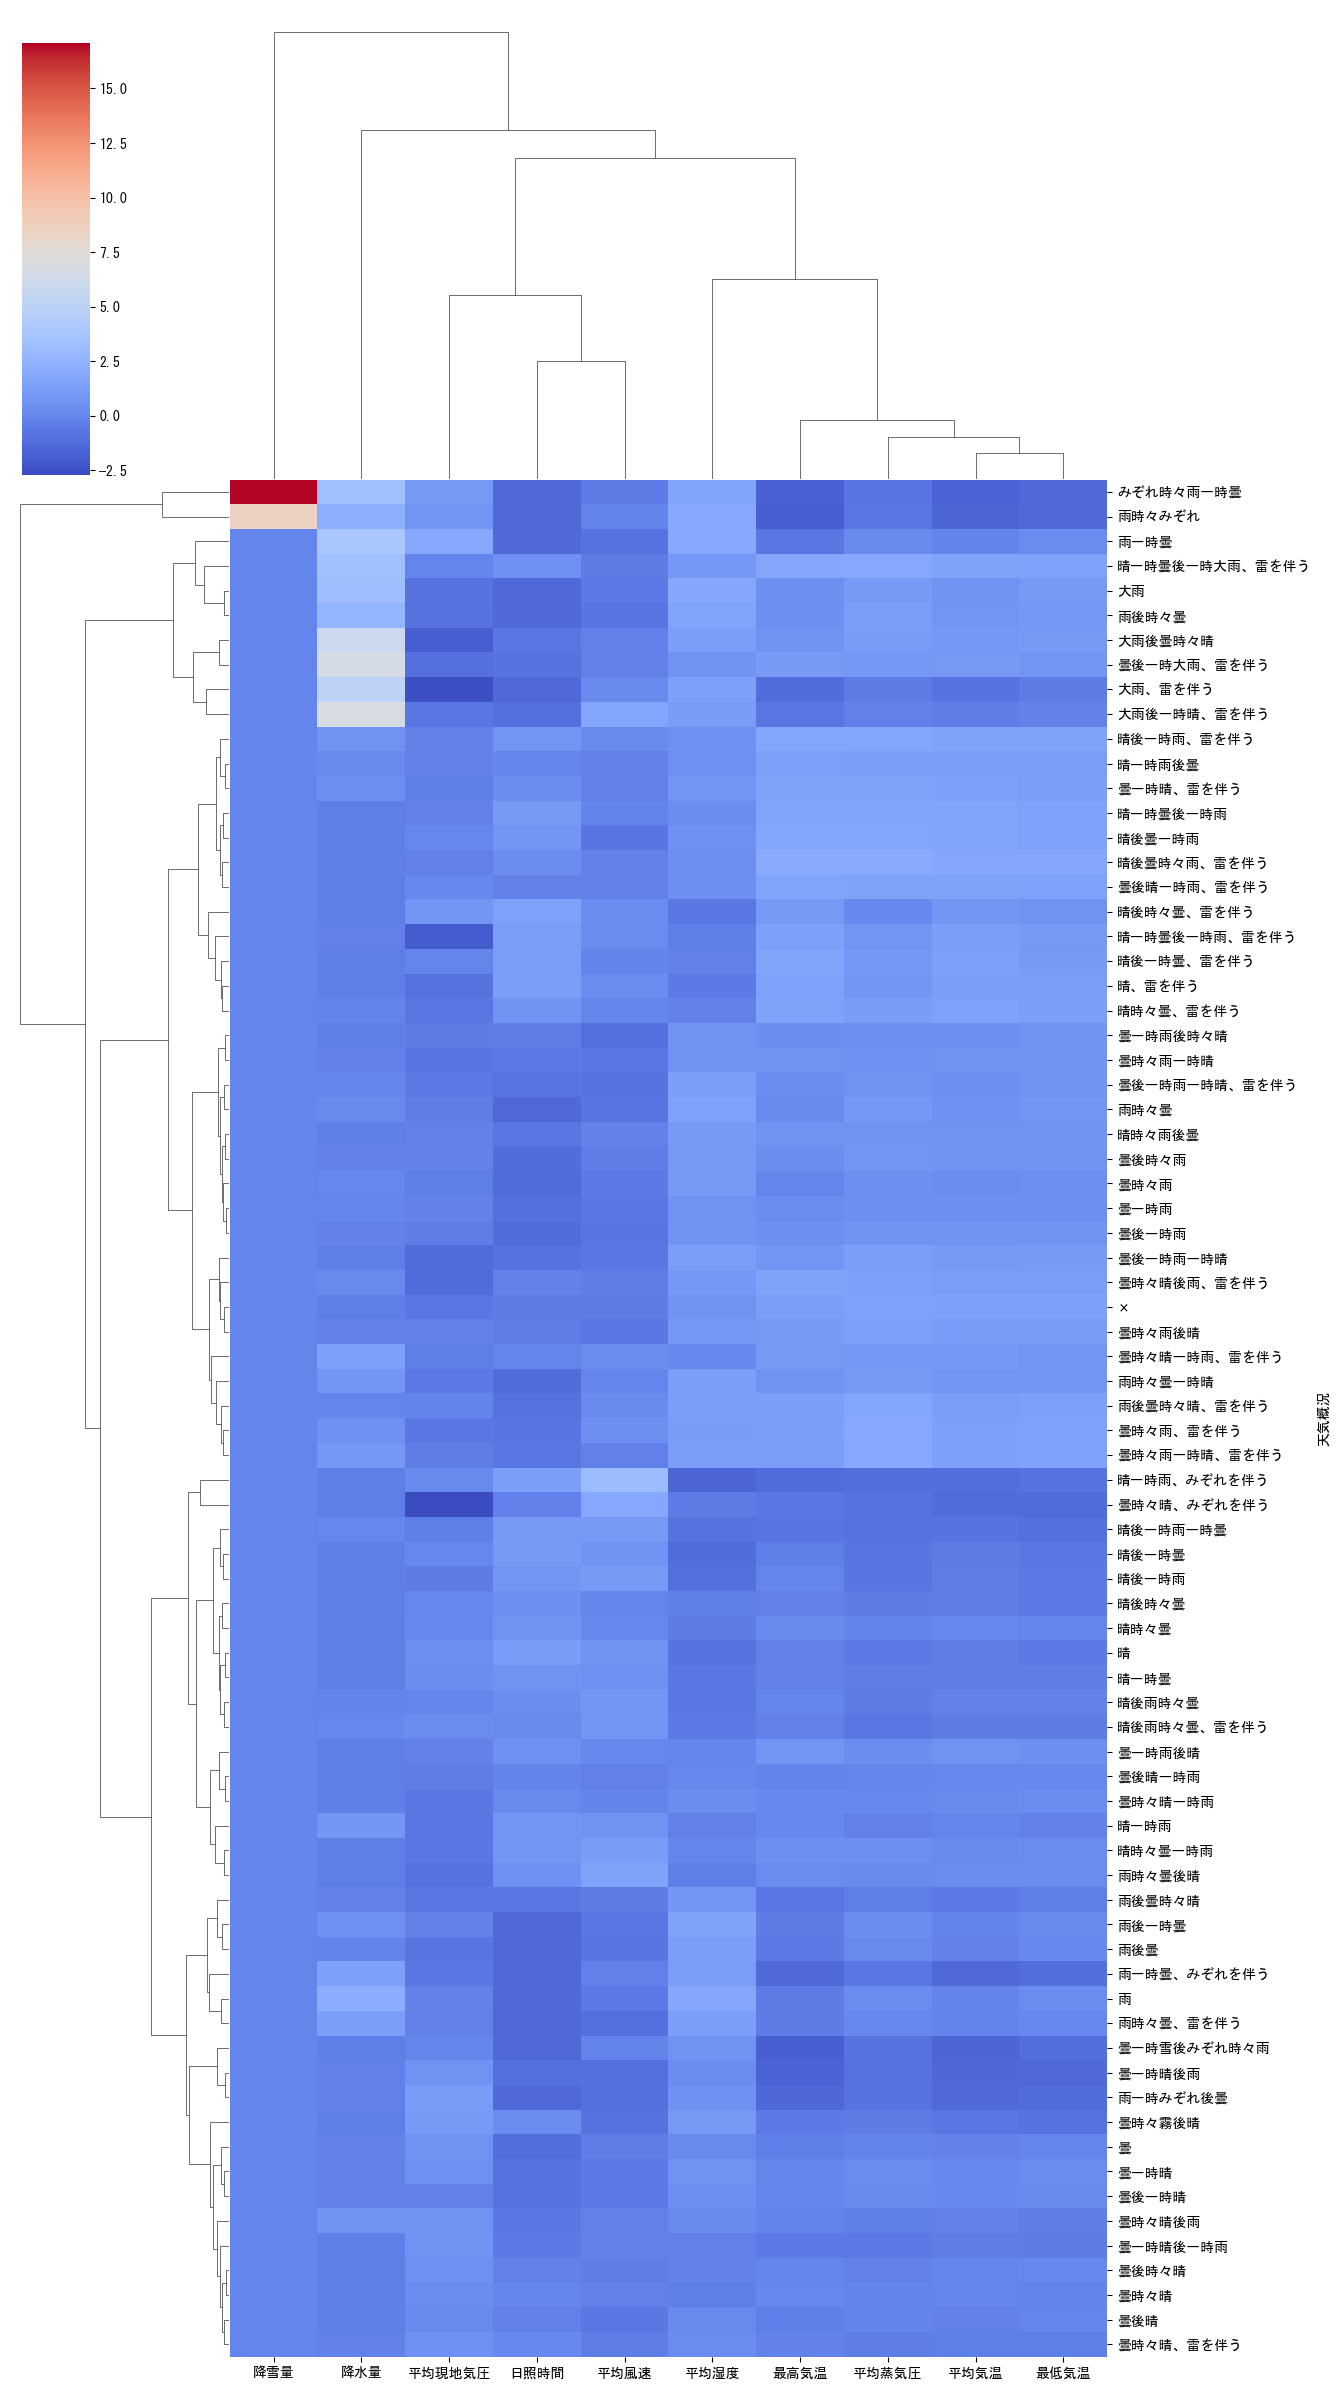

In [79]:
# データフレームの作成しクラスタマップを作成
_df = pd.DataFrame(X_weather, index=Y_target, columns=X_name)
_df = _df.groupby('天気概況').mean()
_df.to_csv('天気概況-気象データ.csv', index=True)
plt.rcParams['font.family'] = 'MS Gothic'
sns.clustermap(_df, method='ward', metric='euclidean', cmap='coolwarm', figsize=(13.5, 24))
plt.show()

　クラスタリングの結果を見ると，”曇系”，”雨系”，”晴系”，”急変系”などで大まかにクラスタリングされていることが確認できる．説明変数も，気温に関わるものの距離が短く，正しくクラスタリングされていることが確認できる．
### 3. $YYYY$ 年 $MM$ 月の気象データの非階層的クラスタリング（k-means法）
#### (1) データの読み込み
　データの読み込みは前章と同様であるため省略する．
#### (2) クラスタ数の決定
　クラスタの重心とデータ点の間の距離の総計をクラスタの良さと定義し，クラスタ数が増えれば，距離の総計は減少するため，減少が緩やかになる（プロットしたグラフが曲がる）点を最適なクラスタ数とみなすというElbow法を用いて，最適なクラスタを決定する．ここで，減少が緩やかになるとは，グラフ全体を仮想的な直線（最初のクラスタと最後のクラスタを結ぶ線）までの垂直距離を計算し，それが最大となるクラスタを見つけ，それをElbowとして特定する．この処理を自動的に行うことのできるkneedというライブラリのKneeLocatorクラスを使用する．

Best cluste is 19.


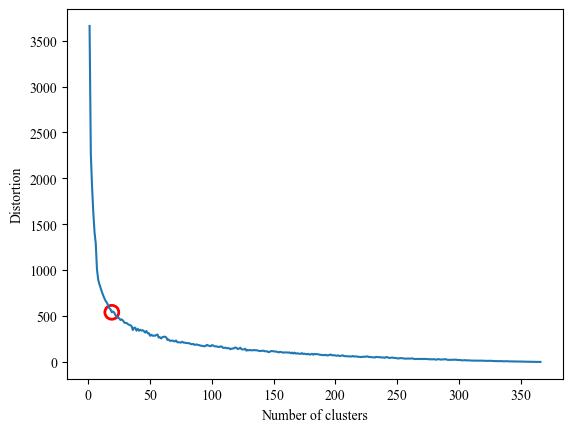

In [80]:
# クラスタ数を決定するために距離の総計を確認
distortions = []
n = len(X_weather)
for i in range(1, n+1):
    km = KMeans(n_clusters=i, init='random', random_state=1)
    km.fit(X_weather)
    distortions.append(km.inertia_)


# Elbow法による最適なクラスタ数の探索
kl = KneeLocator(range(1, n+1), distortions, curve='convex', direction='decreasing')
best_cluster = kl.elbow
print(f'Best cluste is {best_cluster}.')


# グラフの描画
plt.figure()
plt.rcParams['font.family'] = 'Times New Roman'
plt.plot(range(1, n+1), distortions)
plt.scatter(best_cluster, distortions[best_cluster-1], s=100, facecolors='none', edgecolors='red', linewidths=2)
# plt.xticks(range(1, n+1, 1))
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

　したがって，今回の最適なクラスタ数は 19 であると算出された．グラフを確認すると，クラスタ数 19 の部分が概ねElbowの位置であることが視覚的に確認できる．
#### (3) k-means法によるクラスタリング

cluster  0 (23) ['曇時々雨一時晴', '曇後一時晴', '曇時々晴後雨、雷を伴う', '曇時々晴後雨、雷を伴う', '曇一時雨', '曇後時々雨', '曇一時雨後晴', '曇一時晴、雷を伴う', '曇時々雨一時晴、雷を伴う', '曇時々雨後晴', '晴一時雨後曇', '曇時々晴', '曇', '×', '曇後一時晴', '曇時々雨、雷を伴う', '雨後曇時々晴、雷を伴う', '曇時々雨、雷を伴う', '曇一時雨', '曇後晴一時雨、雷を伴う', '曇一時晴', '曇一時晴', '曇後時々雨']
cluster  1 (16) ['曇時々晴', '曇時々晴', '曇時々晴', '曇一時晴後一時雨', '曇', '曇時々晴', '曇後時々晴', '曇時々晴後雨', '曇', '曇一時雨', '曇', '晴時々曇', '晴後雨時々曇', '曇時々晴', '曇時々晴', '曇時々晴']
cluster  2 ( 6) ['晴一時雨', '大雨、雷を伴う', '大雨後一時晴、雷を伴う', '雨後時々曇', '曇後一時大雨、雷を伴う', '大雨後曇時々晴']
cluster  3 (26) ['晴', '晴', '晴一時曇', '晴', '晴', '晴時々曇', '晴', '晴', '晴時々曇', '晴', '晴時々曇', '晴', '晴一時曇', '晴時々曇', '晴', '晴', '晴', '晴', '晴', '晴後一時曇', '晴', '晴', '晴', '晴', '晴', '晴一時曇']
cluster  4 (20) ['晴', '晴後一時曇', '曇後晴', '晴', '晴後時々曇', '晴後一時曇', '晴', '晴時々曇', '曇時々晴', '曇時々晴', '晴後一時雨一時曇', '曇後晴一時雨', '曇時々晴', '曇時々晴', '晴後時々曇', '曇時々晴', '晴後時々曇', '曇時々晴', '晴一時曇', '晴時々曇']
cluster  5 ( 2) ['雨時々みぞれ', 'みぞれ時々雨一時曇']
cluster  6 (32) ['曇一時雨後晴', '晴時々曇', '晴', '晴一時雨', '晴', '晴', '晴後一時雨', '晴', '晴', '晴', '晴時々曇', '晴', '晴後雨時々曇、雷を伴う', '晴後一時曇', '

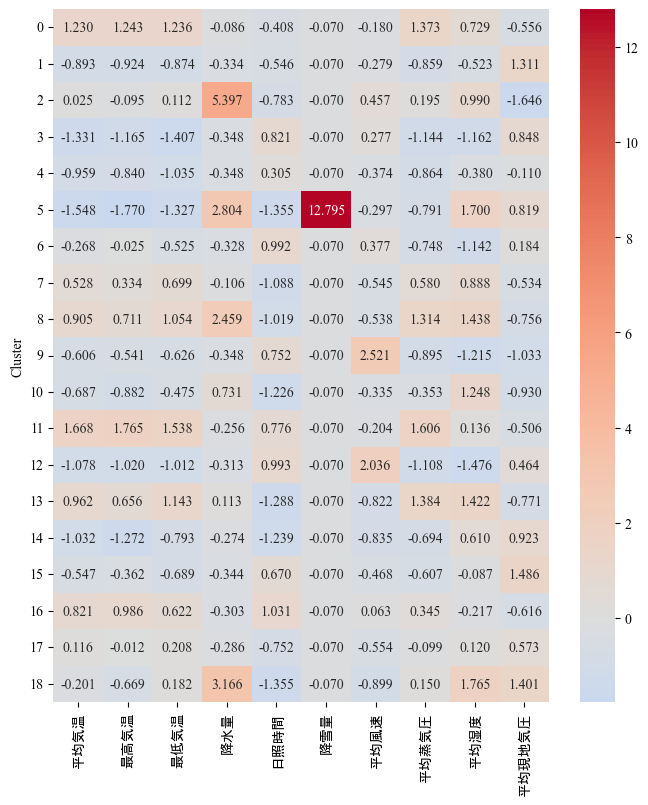

In [81]:
# k-means法によるクラスタリング
kmeans = KMeans(n_clusters=best_cluster, init="random", random_state=1)
cluster_km = kmeans.fit_predict(X_weather)


# 各クラスタの天気概況を確認
for i in range(best_cluster):
    weather_list = []
    for _cluster, _weather in zip(cluster_km, Y_target):
        if i == _cluster:
            weather_list.append(_weather)
    print(f'cluster {i:2.0f} ({len(weather_list):2.0f}) {weather_list}')


# 各クラスタの重心をヒートマップで表示
centers = pd.DataFrame(kmeans.cluster_centers_, columns=X_name)
plt.figure(figsize=(8, 9))
plt.rcParams['font.family'] = 'Times New Roman'
ax = sns.heatmap(centers, annot=True, fmt=".3f", cmap="coolwarm", center=0, cbar=True)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontdict={'family': 'MS Gothic'})
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
plt.ylabel('Cluster')
plt.show()

　k-means法によって作成されたクラスタに関しては，各クラスタに属する天気概況や，気象データの重心表すヒートマップより，それぞれ以下の表ように考察することができる．
| Cluster  | 属性 | 考察（備考） |
|:-------:|:------|:--------|
| 0  | 不安定な曇・雨 | 気温に関するパラメータと平均蒸気圧の値がやや大きく，空気中の水分量が多いことが考えられ，不安定な天気に関するクラスタであると考えられる．一方で，平均湿度が高くならなかった理由は，天気が不安定であるが故に，湿度の変動が大きく，平均したことによって，それがならされたものと考えられる． |
| 1  | 時々雨を伴う曇・晴 | ほとんどのパラメータの重心が0であり，平均現地気圧のみやや大きいため，基本的には高気圧による安定した天気であるが，一時的な雨を伴う曇や晴に関するクラスタであると考えられる． |
| 2  | 一時的悪天候（大雨・雷など） | 降水量の重心の値が大きく，平均現地気圧の重心が小さいため，低気圧（すなわち積乱雲）による比較的短時間の大雨や，雷などを伴う一時的な悪天候に関するクラスタであると考えられる． |
| 3  | 冬の快晴 | 気温に関するパラメータと平均蒸気圧，平均湿度の値がやや小さく，冬場の乾燥した晴の天気に関するクラスタであると考えられる．|
| 4  | 安定した曇・晴 | ほとんどのパラメータの重心が0であるため，安定した天気で，傑出したパラメータの見られない快適な曇や晴に関するクラスタであると考えられる．|
| 5  | 雪・みぞれ | 降雪量の重心がかなり大きな値に隔たっており，降水量の重心も若干高くなっていることから，雪やみぞれに関するクラスタであると考えられる．|
| 6  | 夏の快適な晴（時々夕立） | 日照時間がやや大きく，平均湿度がやや小さいことから夏の中でも湿度の低い快適な晴であると考えられ，時々夕立のため，雨が確認できるものと考えられる．|
| 7  | 曇と一時的な雨 | 日照時間が小さく，平均現地気圧も小さいことから，日は出ていないものと考えられ，低気圧により一時的に雨が降るというクラスタであると考えられる．|
| 8  | 梅雨 | 降水量が多く，気温に関するパラメータと平均湿度もやや大きいため，梅雨の湿気の多い雨に関するクラスタであると考えられる．|
| 9  | 不安定な晴 | 晴も多いが，クラスタ12と異なる部分は，平均現地気圧の重心がやや小さいことであり，これによって局所的な悪天候に見舞われる可能性があるクラスタとして分類されたものと考えられる．|
| 10 | 強風の晴 | 平均風速が大きく，日照時間もやや長いため，風の強い晴に関するクラスタであると考えられる．|
| 11 | 夕立のある猛暑 | 気温に関するパラメータが大きく，平均蒸気圧も大きいため，基本的には晴で，その後夕立とみられる雷雨のある猛暑日に関するクラスタであると考えられる．|
| 12 | 快適な晴 | 平均風速がやや大きく，平均湿度がやや小さいため，快適な晴に関するクラスタであると考えられる．|
| 13 | 局所的な雨 | 降水量は小さいが，平均蒸気圧や湿度は大きく，平均現地気圧は比較的小さいため，低気圧による局所的な雨のある天気に関するクラスタであると考えられる．|
| 14 | みぞれ混じりの雨 | 気温に関する値は小さく，平均現地気圧，湿度は比較的大きいことから，冬でみぞれか雨になるような天気が長い時間見られるクラスタであると考えられる．|
| 15 | 快晴 | 平均現地気圧が大きく，平均湿度も小さいことから，快晴に関するクラスタであると考えられる．|
| 16 | 夏の不安定な晴 | 気温や日照時間がやや大きいことから夏とみられ，基本的には晴であるが，局所的な雷雨に見舞われる可能性があるクラスタとして分類されたものと考えられる．|
| 17 | 変化する曇天 | あらゆるパラメータの重心が0であるが，天気には変化が見られ，天気の変化によってあらゆるパラメータの値がならされたものと考えられ，天気の変わりやすい曇天に関するクラスタであると考えられる．|
| 18 | 持続的な雨 | 降水量の重心が大きく，平均湿度や平均現地気圧の重心もやや大きいことから，高気圧（乱層雲）による比較的長時間の雨が降り続き，一日に渡る雨に関するクラスタとして分類されたものと考えられる．|
### 4. $YYYY$ 年 $MM$ 月の気象データの混合分布モデルに基づくクラスタリング（混合ガウス分布モデル）
#### (1) データの読み込み
　データの読み込みは前章と同様であるため省略する．
#### (2) クラスタ数の決定
　前章と同様，クラスタの重心とデータ点の間の距離の総計をクラスタの良さと定義し，クラスタ数が増えれば，距離の総計は減少するため，減少が緩やかになる（プロットしたグラフが曲がる）点を最適なクラスタ数とみなすというElbow法を用いて，最適なクラスタを決定する．ここで，減少が緩やかになるとは，グラフ全体を仮想的な直線（最初のクラスタと最後のクラスタを結ぶ線）までの垂直距離を計算し，それが最大となるクラスタを見つけ，それをElbowとして特定する．この処理を自動的に行うことのできるkneedというライブラリのKneeLocatorクラスを使用する．
#### (3) 混合ガウス分布モデルによるクラスタリング

cluster  0 (37) ['曇時々雨', '曇時々雨一時晴', '曇後一時晴', '雨時々曇', '曇後時々雨', '曇一時雨', '曇時々雨', '曇後時々雨', '曇時々雨', '曇後一時雨', '曇時々雨', '曇', '曇後一時雨一時晴', '曇後時々雨', '曇後一時雨', '曇一時雨', '曇時々雨', '曇一時晴', '曇時々雨一時晴', '曇後一時雨', '曇時々雨', '曇後晴', '曇時々雨', '曇後一時雨一時晴、雷を伴う', '曇', '曇一時雨後時々晴', '曇一時晴', '曇時々雨', '雨後曇時々晴', '晴時々雨後曇', '曇後晴一時雨', '曇', '曇', '曇一時雨', '雨時々曇', '曇時々雨一時晴', '曇後一時晴']
cluster  1 ( 8) ['晴', '晴後一時雨', '晴後一時曇', '曇時々晴一時雨、雷を伴う', '晴後一時曇', '晴', '晴時々曇', '晴後一時曇']
cluster  2 (36) ['晴', '晴後一時曇、雷を伴う', '晴時々曇', '曇一時晴、雷を伴う', '晴一時雨後曇', '曇時々晴', '晴時々曇', '晴一時曇', '晴時々曇', '曇時々晴', '曇時々晴', '曇時々晴', '曇時々晴', '晴', '晴後曇時々雨、雷を伴う', '晴時々曇、雷を伴う', '晴', '晴', '晴、雷を伴う', '晴時々曇、雷を伴う', '晴時々曇', '晴時々曇', '晴', '晴', '雨時々曇後晴', '晴時々曇', '晴一時曇後一時雨', '曇時々晴一時雨、雷を伴う', '晴時々曇一時雨', '晴', '晴一時曇', '晴後一時雨、雷を伴う', '晴後曇一時雨', '晴後一時雨、雷を伴う', '曇一時雨', '曇後晴一時雨、雷を伴う']
cluster  3 ( 1) ['みぞれ時々雨一時曇']
cluster  4 (10) ['曇一時晴後雨', '雨一時みぞれ後曇', '曇時々晴', '曇後一時晴', '曇', '曇時々晴後雨', '曇', '曇', '曇', '曇一時晴']
cluster  5 ( 8) ['晴', '晴一時曇', '晴', '晴', '晴一時雨、みぞれを伴う', '晴後雨時々曇、雷を伴う', '晴後一時雨一時曇', '晴後一時曇']
clus

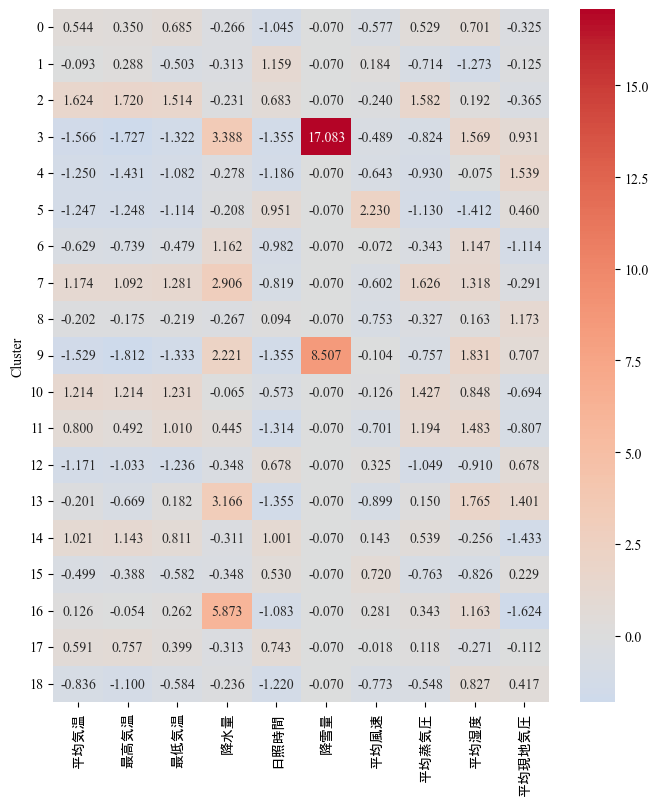

In [85]:
# 混合ガウス分布モデルによるクラスタリング
clf = GaussianMixture(n_components=best_cluster)
cluster_clf = clf.fit_predict(X_weather)


# 各クラスタの天気概況を確認
for i in range(best_cluster):
    weather_list = []
    for _cluster, _weather in zip(cluster_clf, Y_target):
        if i == _cluster:
            weather_list.append(_weather)
    print(f'cluster {i:2.0f} ({len(weather_list):2.0f}) {weather_list}')


# 各クラスタの重心をヒートマップで表示
centers = pd.DataFrame(clf.means_, columns=X_name)
plt.figure(figsize=(8, 9))
plt.rcParams['font.family'] = 'Times New Roman'
ax = sns.heatmap(centers, annot=True, fmt=".3f", cmap="coolwarm", center=0, cbar=True)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontdict={'family': 'MS Gothic'})
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
plt.ylabel('Cluster')
plt.show()

### 感想  
　クラスタの番号は異なるものの，k-means法と混合ガウス分布モデルでは，同じようなクラスタリング結果が得られた？ものと考えられる．各クラスタのデータ数とクラスタの番号が異なるため，これらの類似度について上手く定量化することができず，比較することができなかった．
　